# *League of Legends* Competitive Match Data

⚠️ **Note** ⚠️ You'll probably want to be at least a little bit familiar with [*League of Legends*](https://en.wikipedia.org/wiki/Video_game) and its terminology to use this data set. If not, one of the other data sets may be more interesting to you.

Welcome to Summoner's Rift!

In this project, you will look at a large data set of information on players and teams from over 10,000 *League of Legends* competitive matches. There are many questions that can be answered using this data, such as:
- Looking at [tier one professional leagues](https://en.wikipedia.org/wiki/List_of_League_of_Legends_leagues_and_tournaments), which league has the most "action-packed" games? Is the amount of "action" in this league significantly different than in other leagues? Note that you'll have to come up with a way of quantifying "action".
- Which competitive region has the highest win rate against teams outside their region? Note you will have to find and merge region data for this question as the dataset does not have it.
- Which role "carries" (does the best) in their team more often: ADCs (Bot lanes) or Mid laners?
- Is (DSC 80 tutor) Costin's favorite champion (Talon) more likely to win or lose a match?

Of course, you are encouraged to pursue a question that is not listed above.



### Getting the Data
The dataset can be found on the [Oracle's Elixir](https://oracleselixir.com/tools/downloads) website.

You can use the most up-to-date match data file with more than 100,000 rows. You may use the older datasets if you wish, but keep in mind that League of Legends changes significantly between years. This can make it difficult to combine data from different years, or to make comparisons between years.

### Cleaning and EDA
- Clean the data.
    - Note that each `gameid` corresponds to up to 12 rows -- one for each of the 5 players on both teams and 2 containing summary data for the two teams (try to find out what distinguishes those rows). After selecting the line of inquiry, make sure to remove either the player rows or the team rows so as not to have issues later in your analysis.
    - Many columns should be of type `bool` but are not.
- Understand the data in ways relevant to your question using univariate and bivariate analysis of the data as well as aggregations.

### Assessment of Missingness
- Assess the missingness per the requirements in `project03.ipynb`

### Hypothesis Test / Permutation Test
Find a hypothesis test or permutation test to perform. You can use the questions at the top of the notebook for inspiration.

# Summary of Findings

### Introduction
The dataset consists of instances of players in games as rows and a huge number of columns. The first step for our project was to select the columns we are going to use. Our questions required the `'champion'`, `'result'` and `'visionscore'` columns. We want to see if there is any correlation between the champion picked and the result of the game. We also want to see if the visionscore has any connection with the result of the game. We also kept other columns from the dataset to test other ideas we had and to verify our work.

### Cleaning and EDA
To clean the dataset, we dropped the rows with missing `'champion'` and `'visionscore'` values because our analysis depends on these columns. To explore the data, we first plotted the champions with the highest winning proportion. That lead us to finding out a problem: some champions rarely appear in the dataset and therefore their winning proportions are too noisy (too high or too low). We decided on a certain cutoff for the acceptable frequency of the champion in the dataset to include them in our analysis. This cuttoff was picked after we plotted the winning proportions with the ordered frequency of champions. We confirmed our suspicion and saw the winning proportions being too noisy at the left end of the graph (where the frequency is lowest). In the end, we had a dataset with the columns we needed and without the rows of missing important values.

### Assessment of Missingness
From the dataframe that we chose to use and answer the question that we chose above, we saw the `'champion'`, `'visionscore'` columns are missing. To verify that the missingness of `'champion'` is MCAR (we were expecting it as missing completely at random, not not missing at random), we made a pivot table to see if the winning chance in missing values are same as the winning chance in non-missing values. We was able to see there is minor difference (less than 0.0001 difference that can be negligible). To double confirm that the no difference in missingness and winning chance were not just in the given dataset, we did permutation test to check if there is difference when we shuffle the `'champion'` and find the winning chance again. At the end of the permutation testing on the missingness, we was able to see the p-value is approximately 1.00 (saying that the missingness of `'champion'` does not affect the winning chance). Therefore, missingness of `'champion'` is MCAR in the question that we wanted to test.

### Hypothesis Test
We did two tests on this part.
1. [Bootstrap Test] By sampling, check the absolute difference in means between winner champions' vision score and loser champions' vision score
2. [Permutation Test] By shuffling, check the absolute difference in means bewtween the winner champions' vision score and loser champions' vision score are from same distribution. See if there is significant difference between the two distributions

For the first testing, we use bootstraping strategy to get samples of 'visionscore' and 'result' (winning chance). We compared the winners' mean vision score and losers' mean vision score. As a result, we were able to see that values(difference in sample means) less than the observation difference are above 0.05 rejection region, so it fails to reject the null hypothesis that there is no difference between the sizes of vision score and the winning chances. When we ran the test multiple times and plotted the p-values in a histogram we kept getting p-values ranging between near 0 and near 1 in a bimodal fashion. Most of the p-values were 1s, therefore the null hypothesis is failed to be rejected.

For the second test, we ran a permutation test to see if there is a difference of mean visionscore between winners and losers. We found that there is a statistically significant difference in mean visionscore between winners and losers. **So we reject the null hypothesis.** Winners had a higher mean visionscore.

# Code

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures

### Cleaning and EDA

**Reading the data into a Dataframe**

We are going to explore if there is any connection between the champions in a team and the result of the match. We only need certain columns to perform this analysis so we are going to select them from the full dataset.

In [2]:
raw_matches = pd.read_csv('2022_LoL_esports_match_data_from_OraclesElixir_20221108.csv')

cols_to_keep = [
'gameid',
'datacompleteness', #
'year',
'patch',
'side',
'position',
'teamid',
'champion',
'gamelength',
'result',
'visionscore'
]

raw_matches = raw_matches[cols_to_keep]

C:\Users\jyson\anaconda3\envs\dsc80\lib\site-packages\IPython\core\interactiveshell.py:3378: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


### Cleaning The Dataset ###


First, let's look at the missing values and address them for our analysis.

In [246]:
raw_matches.isna().sum()

gameid                  0
datacompleteness        0
year                    0
patch                 108
side                    0
position                0
teamid               1914
champion            24418
gamelength              0
result                  0
visionscore            12
dtype: int64

We have missing values in:
- `'patch'`: missing from a small number of rows, can be dropped.
- `'teamid'`: the missing values in this column, although small, will only affect **team-wise analysis.**
- `'champion'`: missing from a significant number of rows **(over 16%)**. We have to drop these rows because our analysis depends on the champion.
- `'visionscore'`: contains 12 missing values which is the number of players in a match, meaning it's missing the data from **1 match.** These rows can be dropped.

Let's fix the missing values:

In [247]:
#
matches = raw_matches[(~raw_matches.patch.isna()) & (~raw_matches.champion.isna()) & (~raw_matches.visionscore.isna())]
matches_all_teams = matches[~matches.teamid.isna()]

What champions are used most commonly? (Top 20 specifically)

<AxesSubplot:xlabel='Champion', ylabel='Proportion (%)'>

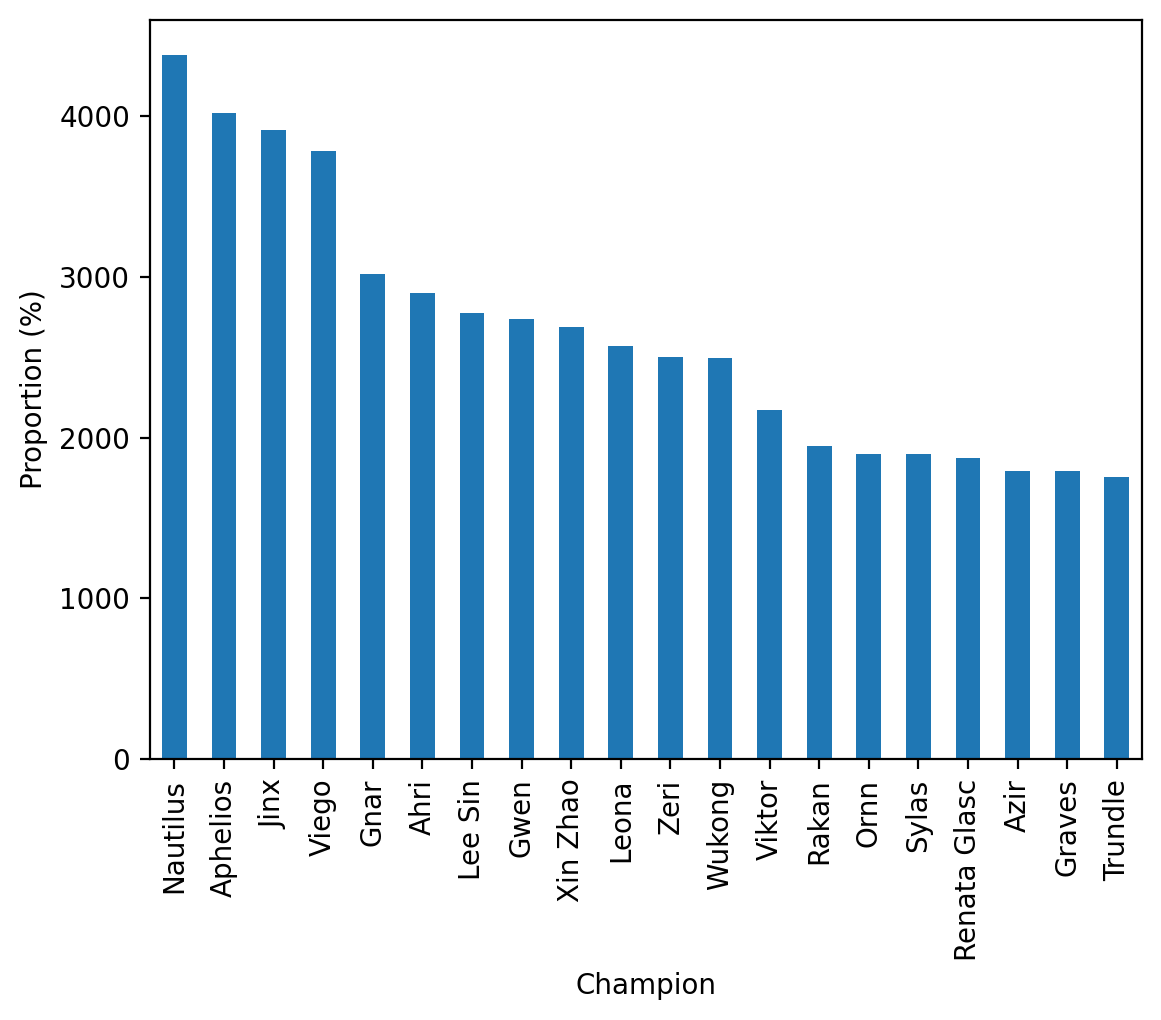

In [248]:
champion_freq = matches.groupby('champion').count()['gameid']

champion_freq.sort_values(ascending=False)[:20].plot(kind='bar', ylabel='Proportion (%)', xlabel='Champion')

What champion has the highest percentage of wins when chosen by a player?

In [249]:
matches.groupby('champion')['result'].mean().sort_values(ascending=False)[:5]

champion
Warwick           1.000000
Aurelion Sol      0.833333
Nunu & Willump    0.647059
Brand             0.600000
Kha'Zix           0.590909
Name: result, dtype: float64

*Warwick* has a 100% winrate 🤔 

That doesn't seem right until you look at the least frequent champions in the dataset:

In [250]:
matches.groupby('champion')['gameid'].count().sort_values()[:5]

champion
Warwick         1
Fizz            3
Master Yi       4
Rammus          5
Aurelion Sol    6
Name: gameid, dtype: int64

The highest and second highest proportions of wins are amongst the lowest 5 frequent players in the dataset.
This is especially a problem because the proportion of wins is going to be very noisy and inaccurate due to the extremely small sample size.

To solve this problem, we need to assign a cutoff for the acceptable number of appearances in the dataset for a champion.
To do this let's first graph the winrate alongside the sorted frequency of champions.

Text(0, 0.5, 'Frequency')

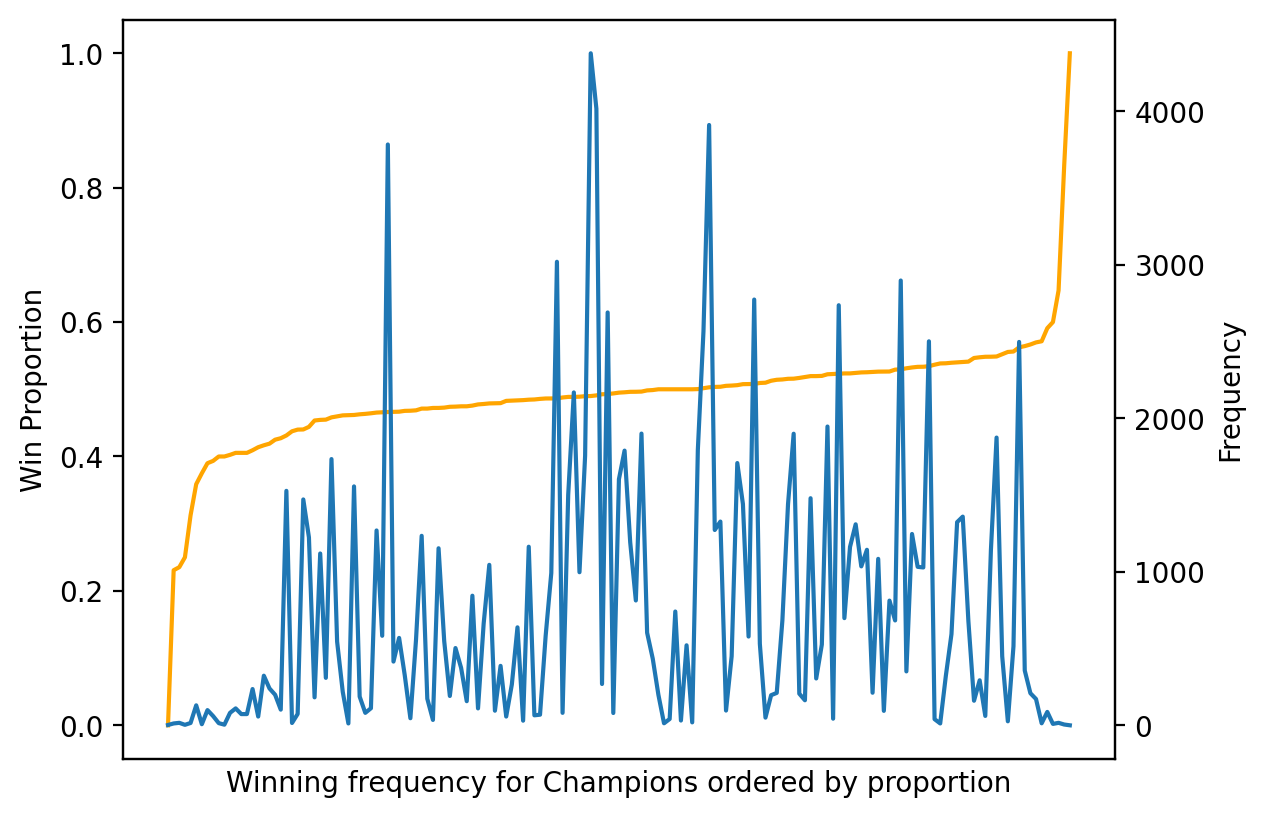

In [251]:
# Dataframe containing champions as rows with their win percentage and frequency in the matches as columns
champ_wins = pd.DataFrame({'win percentage': matches.groupby('champion')['result'].mean(), 'frequency of champion': champion_freq})
# We want to see if
champ_wins = champ_wins.sort_values(by='win percentage')

# Plotting
fig, ax = plt.subplots(sharex=True)
# ax.get_xaxis().set_visible(False)
ax.set_xlabel('Winning frequency for Champions ordered by proportion')

ax.plot(champ_wins['win percentage'], color='orange')
ax.set_ylabel('Win Proportion')
ax.tick_params('x', tick1On=False, label1On=False)

ax2 = ax.twinx()
ax2.plot(champ_wins['frequency of champion'])
ax2.set_ylabel('Frequency')



The orange line shows the winning rate. The blue line shows the frequency of the winning for Champions. As we pointed out above, we can see the proportion of winning has outliers. One interesting part to look in this visualization is the left and right ends of the line plot. Some Champions have lower frequency, some of them have inaccurate winning proportions, which can be outlier cases. (continue on the next visualization)

Text(0, 0.5, 'Frequency')

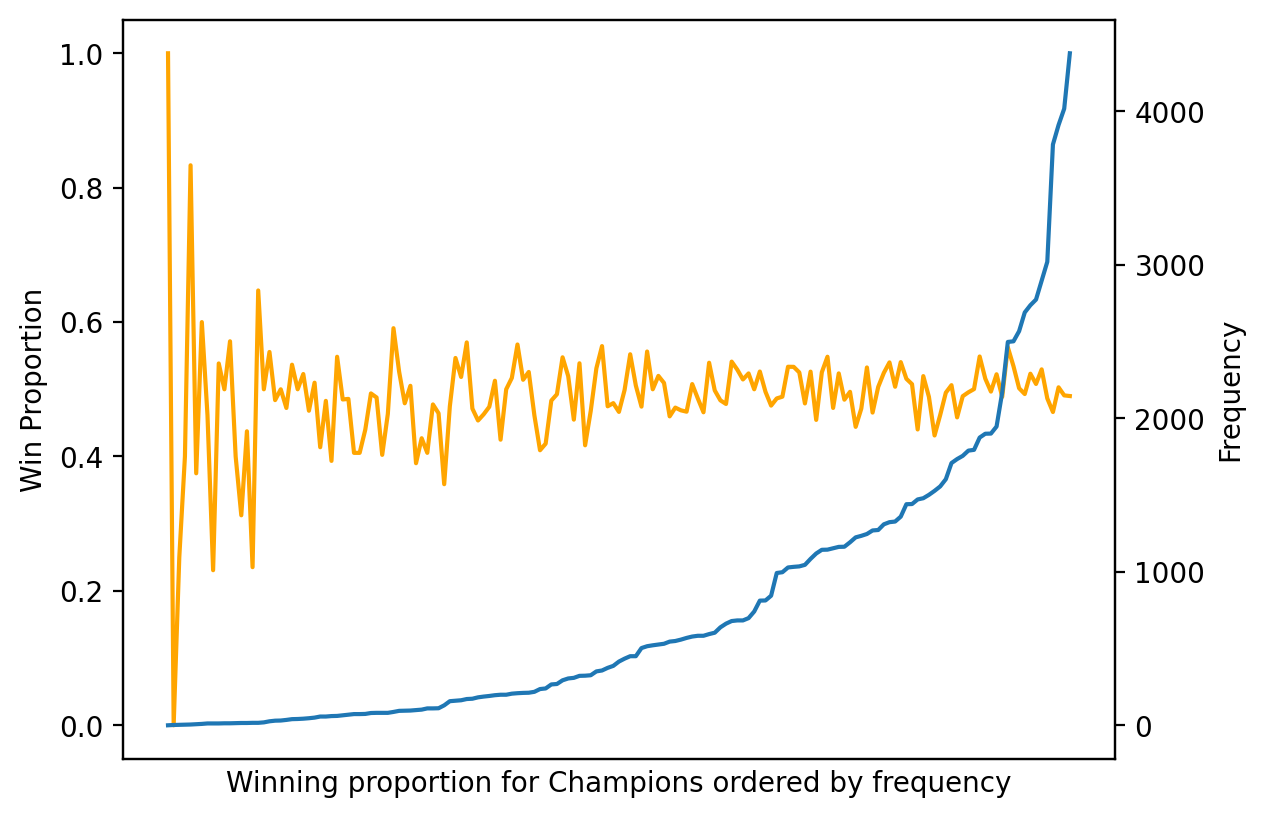

In [252]:
# Dataframe containing champions as rows with their win percentage and frequency in the matches as columns
champ_wins = pd.DataFrame({'win percentage': matches.groupby('champion')['result'].mean(), 'frequency of champion': champion_freq})
# We want to see if
champ_wins = champ_wins.sort_values(by='frequency of champion')

# Plotting
fig, ax = plt.subplots(sharex=True)
# ax.get_xaxis().set_visible(False)
ax.set_xlabel('Winning proportion for Champions ordered by frequency')

ax.plot(champ_wins['win percentage'], color='orange')
ax.set_ylabel('Win Proportion')
ax.tick_params('x', tick1On=False, label1On=False)

ax2 = ax.twinx()
ax2.plot(champ_wins['frequency of champion'])
ax2.set_ylabel('Frequency')



To get the reasonable cutoff point for the data, this visualization is showing the winning proportion for Champions ordered by frequency. We can cut the both edges and take a look the part on the middle to get the reasonable frequency and proportion. We are going to only take a look the part where the proportion gets stable, and we are expecting after the third spike from the left side. (continue.)

Text(0, 0.5, 'Frequency')

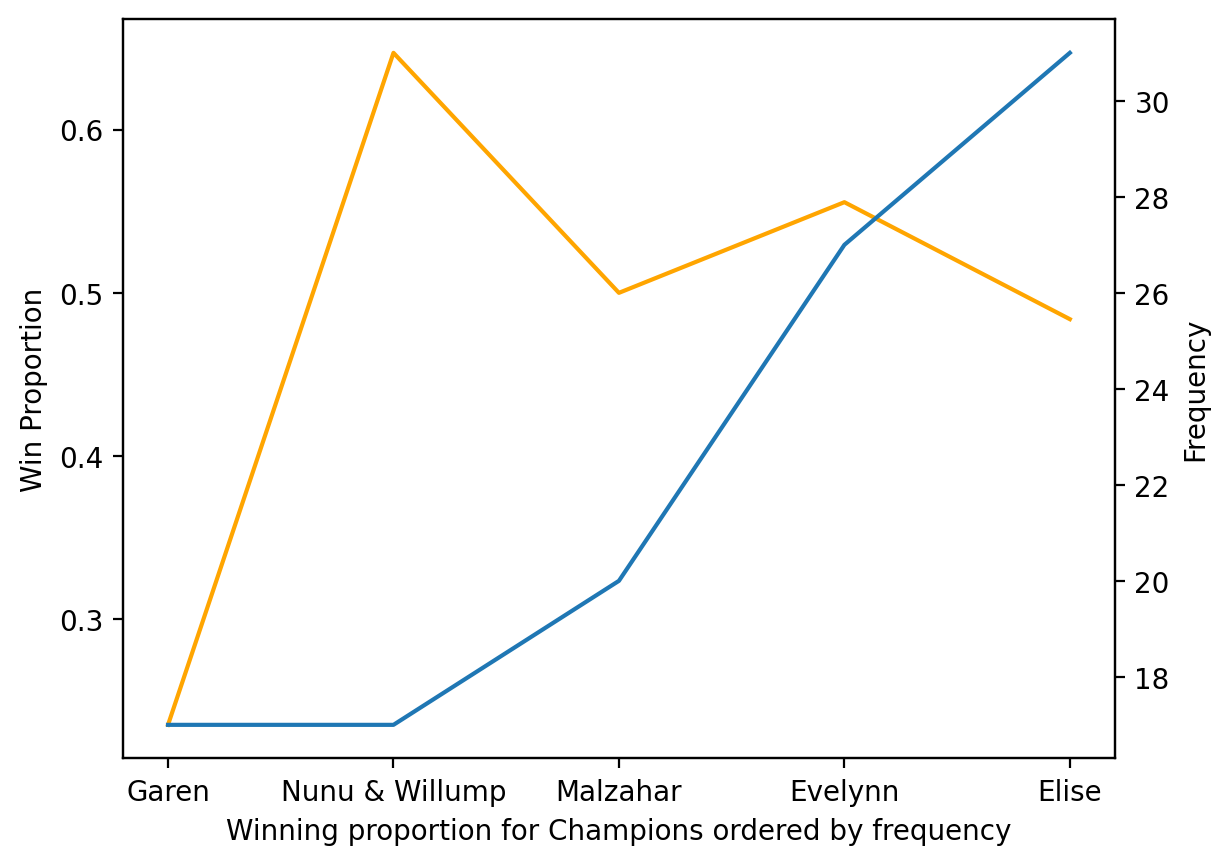

In [253]:
# Dataframe containing champions as rows with their win percentage and frequency in the matches as columns
champ_wins = pd.DataFrame({'win percentage': matches.groupby('champion')['result'].mean(), 'frequency of champion': champion_freq})
# We want to see if
champ_wins = champ_wins.sort_values(by='frequency of champion')[15:20]

# Plotting
fig, ax = plt.subplots(sharex=True)
# ax.get_xaxis().set_visible(False)
ax.set_xlabel('Winning proportion for Champions ordered by frequency')

ax.plot(champ_wins['win percentage'], color='orange')
ax.set_ylabel('Win Proportion')
# ax.tick_params('x', tick1On=False, label1On=False)

ax2 = ax.twinx()
ax2.plot(champ_wins['frequency of champion'])
ax2.set_ylabel('Frequency')



We found the third spike Chapion who is "Nunu & Willump". From now on, we are going to only see the Chapions on the right side of "Nunu & Willump". Starting from "Malzahar" 😎

In [254]:
champ_wins_cleaned = pd.DataFrame({'win percentage': matches.groupby('champion')['result'].mean(), 'frequency of champion': champion_freq})\
    .sort_values(by = "frequency of champion").loc["Malzahar":]
champ_wins_cleaned

,win percentage,frequency of champion
champion,,
Malzahar,0.500000,20
Evelynn,0.555556,27
Elise,0.483871,31
Neeko,0.500000,32
Singed,0.472222,36
...,...,...
Gnar,0.486424,3020
Viego,0.466173,3784
Jinx,0.502940,3911


Text(0, 0.5, 'Frequency')

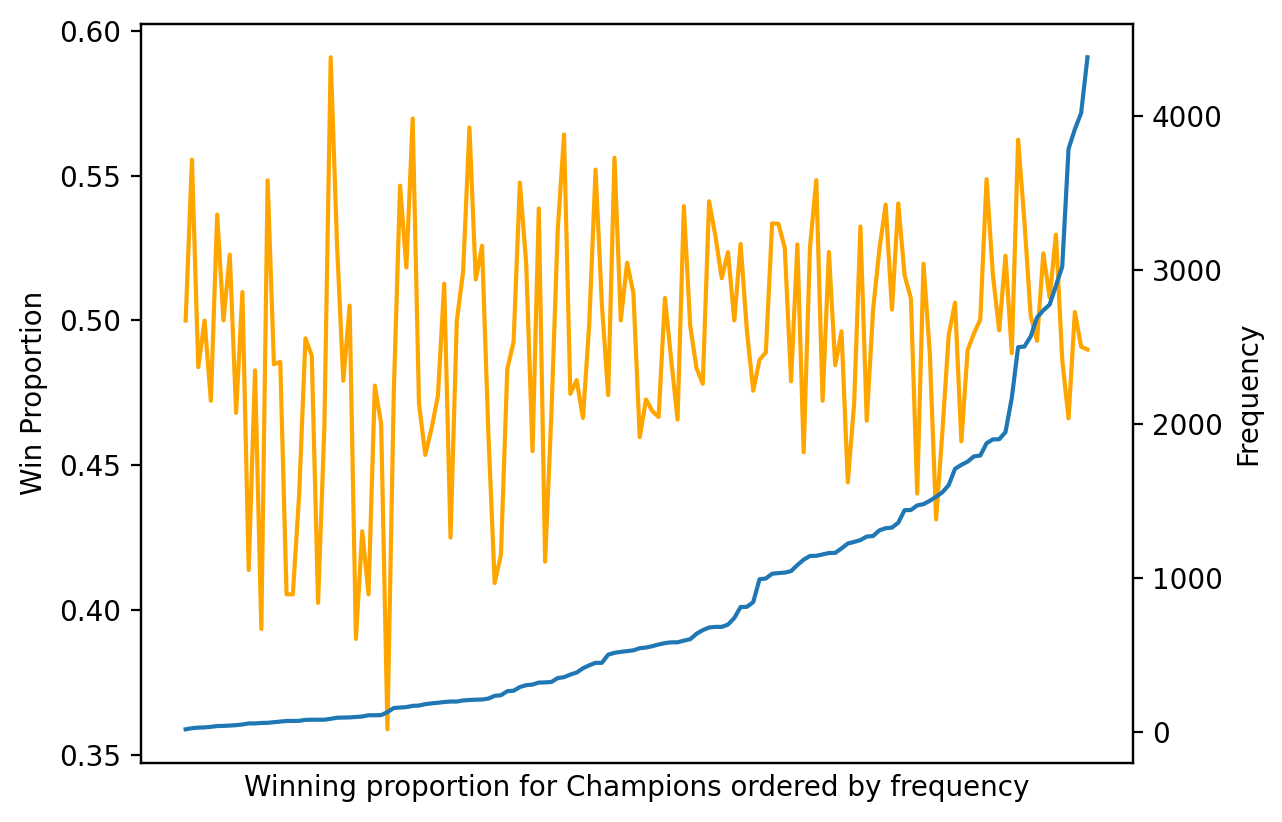

In [255]:
# Plotting
fig, ax = plt.subplots(sharex=True)
# ax.get_xaxis().set_visible(False)
ax.set_xlabel('Winning proportion for Champions ordered by frequency')

ax.plot(champ_wins_cleaned['win percentage'], color='orange')
ax.set_ylabel('Win Proportion')
ax.tick_params('x', tick1On=False, label1On=False)

ax2 = ax.twinx()
ax2.plot(champ_wins_cleaned['frequency of champion'])
ax2.set_ylabel('Frequency')

Compare to the first "Winning Proportion for Champions ordered by frequency", we removed the most noisy parts, and see more reliable information. We are going to use this finding to do the permutation test to find out if champions affect the winning chance.

### Assessment of Missingness

Let's see how many missing values we have in each column.

In [256]:
raw_matches.isna().sum()

gameid                  0
datacompleteness        0
year                    0
patch                 108
side                    0
position                0
teamid               1914
champion            24418
gamelength              0
result                  0
visionscore            12
dtype: int64

Some values on "patch", "teamid", "champion", and "visionscore" columns are missing. We are going to take a look at the "champion" column and see why the values are missing (Missing Completely at Random or Not Missing at Random), and find out if the missing values affect the winning chance.

### Verifying if the champions are MCAR or NMAR

- Each row of `raw_match` belongs to one of two **groups**:
    - Group 1: `'champion'` is missing.
    - Group 2: `'champion'` is not missing.
- We need to look at the distributions of `'result'` – separately for these two groups, and check to see if they are similar.

In [257]:
raw_matches.head()

,gameid,datacompleteness,year,patch,side,position,teamid,champion,gamelength,result,visionscore
0,ESPORTSTMNT01_2690210,complete,2022,12.01,Blue,top,oe:team:68911b3329146587617ab2973106e23,Renekton,1713,0,26.0
1,ESPORTSTMNT01_2690210,complete,2022,12.01,Blue,jng,oe:team:68911b3329146587617ab2973106e23,Xin Zhao,1713,0,48.0
2,ESPORTSTMNT01_2690210,complete,2022,12.01,Blue,mid,oe:team:68911b3329146587617ab2973106e23,LeBlanc,1713,0,29.0
3,ESPORTSTMNT01_2690210,complete,2022,12.01,Blue,bot,oe:team:68911b3329146587617ab2973106e23,Samira,1713,0,25.0
4,ESPORTSTMNT01_2690210,complete,2022,12.01,Blue,sup,oe:team:68911b3329146587617ab2973106e23,Leona,1713,0,69.0


In [258]:
raw_matches.assign(champion_missing = raw_matches["champion"].isna())#["champion_missing"].sum()

,gameid,datacompleteness,year,patch,side,position,teamid,champion,gamelength,result,visionscore,champion_missing
0,ESPORTSTMNT01_2690210,complete,2022,12.01,Blue,top,oe:team:68911b3329146587617ab2973106e23,Renekton,1713,0,26.0,False
1,ESPORTSTMNT01_2690210,complete,2022,12.01,Blue,jng,oe:team:68911b3329146587617ab2973106e23,Xin Zhao,1713,0,48.0,False
2,ESPORTSTMNT01_2690210,complete,2022,12.01,Blue,mid,oe:team:68911b3329146587617ab2973106e23,LeBlanc,1713,0,29.0,False
3,ESPORTSTMNT01_2690210,complete,2022,12.01,Blue,bot,oe:team:68911b3329146587617ab2973106e23,Samira,1713,0,25.0,False
4,ESPORTSTMNT01_2690210,complete,2022,12.01,Blue,sup,oe:team:68911b3329146587617ab2973106e23,Leona,1713,0,69.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...
146503,ESPORTSTMNT01_3173307,complete,2022,12.20,Red,mid,oe:team:2b7b9f30577e4eb59af48370ce8679c,Yone,2587,0,40.0,False
146504,ESPORTSTMNT01_3173307,complete,2022,12.20,Red,bot,oe:team:2b7b9f30577e4eb59af48370ce8679c,Kalista,2587,0,63.0,False
146505,ESPORTSTMNT01_3173307,complete,2022,12.20,Red,sup,oe:team:2b7b9f30577e4eb59af48370ce8679c,Taric,2587,0,98.0,False
146506,ESPORTSTMNT01_3173307,complete,2022,12.20,Blue,team,oe:team:c94195cef56d1eabb7e0304efad4c47,NaN,2587,1,301.0,True


In [259]:
result_dist = (
    raw_matches
    .assign(champion_missing = raw_matches["champion"].isna())
    .pivot_table(index = "result", columns = "champion_missing", aggfunc = "size")
    )
result_dist = result_dist / result_dist.sum()
result_dist

champion_missing,False,True
result,,
0,0.500123,0.500123
1,0.499877,0.499877


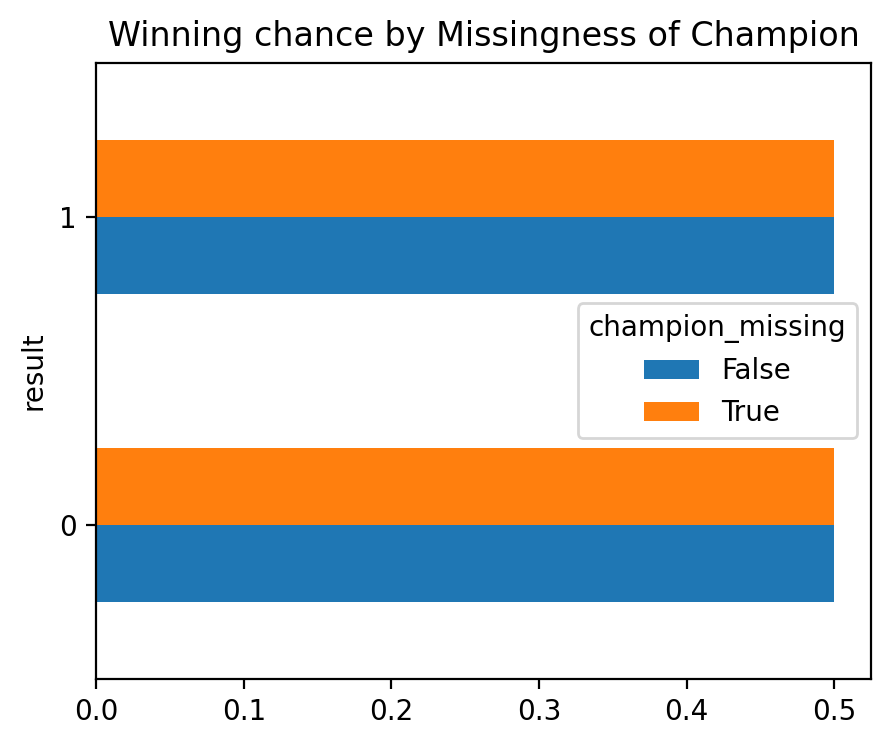

In [260]:
result_dist.plot(kind='barh', figsize=(5, 4), title='Winning chance by Missingness of Champion');

At this point, we can see the missingness of Champion doesn't really make a difference in the Winning chance (result) mean. But to double confirm that it wasn't the coincidence that they don't have difference, we are going to use permutation test and Total Variation Distance (since it is categorical; Win: 1 and Lose: 0) to prove the statement.

In [261]:
# reference from the lecture 8
shuffled = raw_matches.copy()
shuffled['champion_missing'] = shuffled['champion'].isna()

n_repetitions = 500
tvds = []
for _ in range(n_repetitions):
    shuffled['result'] = np.random.permutation(shuffled['result'])
    pivoted = (
        shuffled
        .pivot_table(index='champion_missing', columns='result', aggfunc='size')
        .apply(lambda x: x / x.sum(), axis=1)
    )
    
    tvd = pivoted.diff().iloc[-1].abs().sum() / 2
    tvds.append(tvd)

In [262]:
obs_tvd = result_dist.diff(axis=1).iloc[:, -1].abs().sum() / 2
obs_tvd

0.0

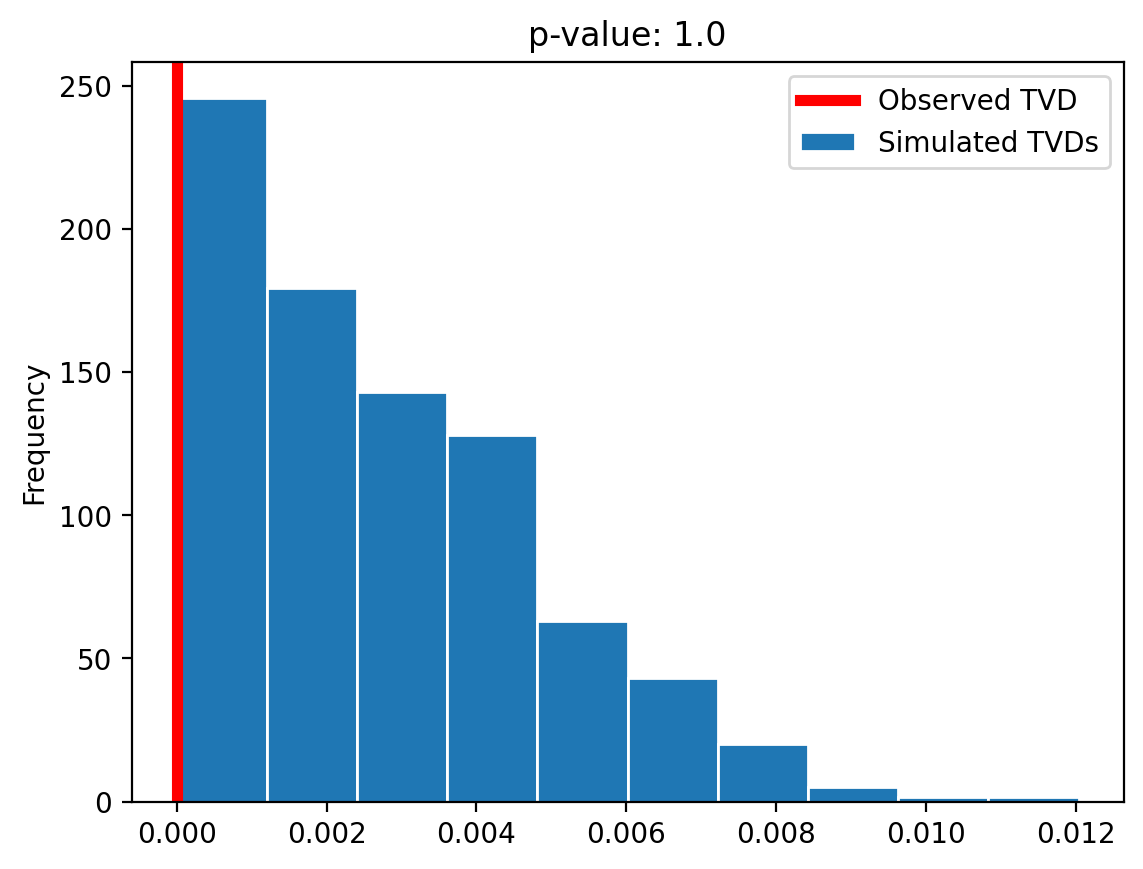

In [263]:
pval = np.mean(tvds >= obs_tvd)

pd.Series(tvds).plot(kind='hist', density=True, ec='w', bins=10, title=f'p-value: {pval}', label='Simulated TVDs')
plt.axvline(x=obs_tvd, color='red', linewidth=4, label='Observed TVD')
plt.legend();

We can confirm that there is no difference between missingness of Champion on their winning chance. Missing values on the `'champion'` column are **Missing Completely at Random** and they don't affect the winning mean.

### Hypothesis Test

Additionally with the question, **"Do the champions affect the winning chances?"** that we show right above, we are going to look **if the vision score also affect their winning chance.**

1. [Hypothesis Test] Check the diffence in means between winner champions' vision score and loser champions' vision score
2. [Permutation Test] Check the distribution of the winner champions' vision score and loser champions' vision score are from same distribution. See if there is significant difference between the two distributions

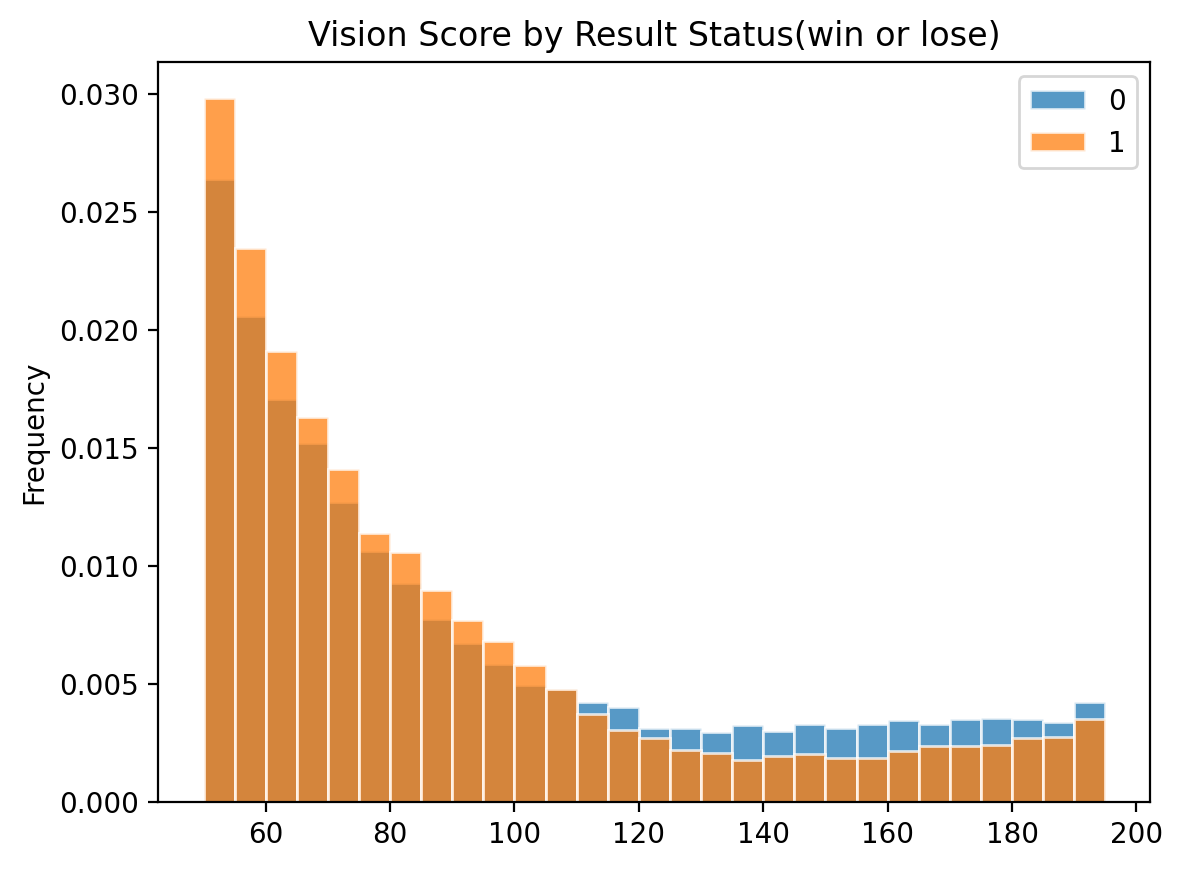

In [264]:
title = "Vision Score by Result Status(win or lose)"

(
    raw_matches
    .groupby('result')['visionscore']
    .plot(kind='hist', density=True, legend=True,
          ec='w', bins=np.arange(50, 200, 5), alpha=0.75,
          title=title)
);    

Interestingly, it appears that the lower the visionscore is the higher the proportion of winnings and the higher the visionscore the less the winning chances.

### Testing 1

* Testing strategy: Hypothesis Testing
* Test statistic: Absolute difference between winner champions' average and loser champions' average

**Null hypothesis**: In the samples, vision score of Champion's who win and Champion's who lose have the same vision score averages. 

**H<sub>0</sub>：Both means are the same**


**Alternative hypothesis**: In the population, champions who win have a higher vision score average than champions who lose the battles. 

**H<sub>a</sub>：Mean vision score for winners and mean vision score for losers are different.**


In [265]:
# observation
observed_diff_mean = np.abs(raw_matches.groupby("result").mean()["visionscore"].iloc[1] - raw_matches.groupby("result").mean()["visionscore"].iloc[0])
observed_diff_mean

8.844262115475075

We are going to use sampled values to find the difference in means **using bootstraping strategy**.

<AxesSubplot:ylabel='Frequency'>

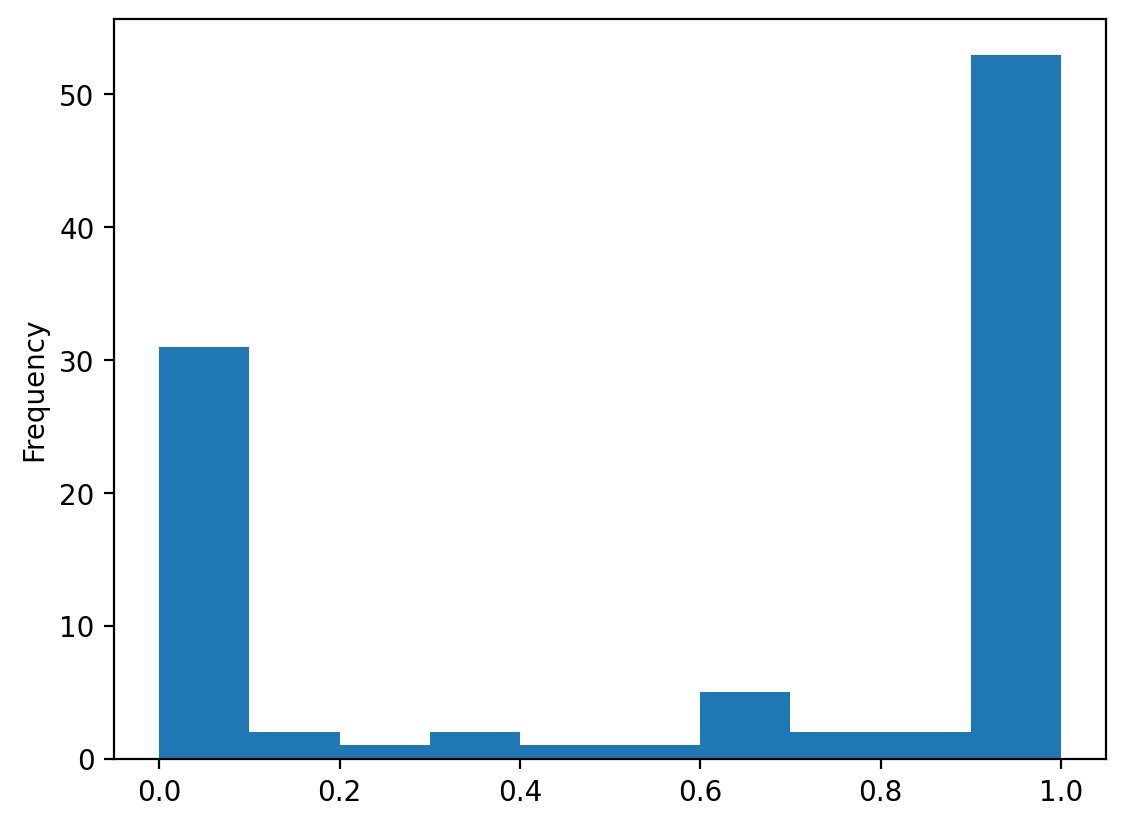

In [266]:
sampled = raw_matches.copy()[['result', 'visionscore']]
pvals = []
for _ in range(100):
    n_repetitions = 100
    diff_lst_samp = []
    for _ in range(n_repetitions):
        sampled = sampled.sample(sampled.shape[0], replace = True) # bootstrap
        diff_means_samp = np.abs(sampled.groupby("result").mean()["visionscore"][1] - sampled.groupby("result").mean()["visionscore"][0])
        diff_lst_samp.append(diff_means_samp)

    p_value_sample = np.mean(diff_lst_samp > observed_diff_mean)
    pvals.append(p_value_sample)

pd.Series(pvals).plot(kind='hist')

Even though the distribution of p-values is bimodal near 1 and 0, the majority of the p-values are 1s so we can assume that the null hypothesis is not rejected.

### Testing 2

* Testing strategy: Permutation Testing
* Test statistic: Absolute difference between winner champions' average and loser champions' average (same as hypothesis testing)

- **Null hypothesis**: In the samples, vision score of champions who win and champion who lose have the same vision score averages.

**H<sub>0</sub>：Both means are the same**


- **Alternative hypothesis**: In the population, champions who win have higher mean vision scores than champions who lose the battles.

**H<sub>a</sub>：Mean vision score for winners and mean vision score for losers are different.**


In [267]:
observed_abs_diff_mean = np.abs(raw_matches.groupby("result").mean()["visionscore"][1] - raw_matches.groupby("result").mean()["visionscore"][0])
observed_abs_diff_mean

8.844262115475075

In [269]:
permutation = raw_matches.copy()

n_repetitions = 500
diff_lst_perm = []
for _ in range(n_repetitions):
    permutation['result'] = np.random.permutation(permutation['result'])
    diff_means_perm = np.abs(permutation.groupby("result").mean()["visionscore"][1] - permutation.groupby("result").mean()["visionscore"][0])
    diff_lst_perm.append(diff_means_perm)

p_value_permutation = np.mean(diff_lst_perm > observed_diff_mean)
p_value_permutation

0.0

Permutation testing shows us that the distribution of winner champions' vision score and loser chapions' vision scores are from different distributions. There is a connection between visionscore and the result.